In [34]:
import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np
import pandas as pd
import scipy as sp
from scipy.interpolate import interp1d
from scipy import fft    

import re
import librosa
import random

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import librosa.display
import IPython.display as ipd
import os

import warnings
warnings.filterwarnings('ignore')

import IPython
%matplotlib notebook

In [2]:
# Set up path to data files (not available on Github)

path_raw =  os.path.abspath(os.pardir+"/Data/Data_Raw_Labeled/") + "/"
path_waves =  os.path.abspath(os.pardir+"/Data/Data_Wave_Arrays/") + "/"
path_labels =  os.path.abspath(os.pardir+"/Data/Data_Labels/") + "/"
path_mic = os.path.abspath(os.pardir+"/Data/Mic_FR/") + "/"


# Function Definitions

In [18]:
def cutter(x, sr=44100):
    '''
    cutter(x) takes wave amplitude array (x) and trims the edges to return a half-second signal
    centered around the input midpoint. 
    '''

    mid_idx = int(len(x)//2) # middle index
    hlf_wdw = int(0.5*(sr)/2.0) # half of 0.5 sec window in # of elements 
    
    return x[mid_idx-hlf_wdw:mid_idx+hlf_wdw] 

def raw_to_wave_array(path_raw):
    '''
    Input is path to the raw wave files (.wav) from academic dataset containing ~1 sec sung vowels
    whose classification label (breathy, normal, flow, and pressed) is specified in the filename.
    
    raw_to_wave_array(path_raw) takes the path of the raw wave files, trims them at the midpoint,
    and stacks them in a numpy array where each row is a single data point. In parallel, we extract 
    the corresponding class labels from raw filenames and use them to construct y4. 
    
    This function returns the data array (wave_array) and label array (y4).
    '''
    
    # counters
    cb = 0 # count breathy
    cn = 0 # count neutral
    cf = 0 # count flow
    cp = 0 # count pressed

    # get all files in the path_raw folder
    filelist = [x for x in os.listdir(path_raw) if not x.startswith('.')]

    # initialize labels (y) array - one label for every input file.
    y4 = np.zeros(len(filelist),dtype=int)

    # loop over files
    for index, file in enumerate(filelist[:]):

        print('index=',index)

        if 'breathy' in file:
            label = 0 
            cb += 1
        if 'neutral' in file:
            label = 1 
            cn += 1
        if 'flow' in file:
            label = 2 
            cf += 1
        if 'pressed' in file:
            label = 3 
            cp += 1
        try: # try to load wave file using librosa
            x, sr = librosa.load(path_raw+file,sr=44100) 
            if len(x) < 22050: # if less than half a second, print warning
                print('WARNING, INPUT LESS THAN 0.5 SECS!')
        except:
            print(file+'has an issue!')

        # get trimmed wave
        trimmed_wave = cutter(x,sr)
        
        # store y4 label
        y4[index] = label
        
        # stack to produce data array
        if index == 0:
            wave_array = trimmed_wave
        else:
            wave_array = np.vstack((wave_array,trimmed_wave))
    
    # save data & label arrays
    np.savetxt(path_labels+'y4'+'.txt',y4)
    np.savetxt(path_waves+'W'+'.txt',wave_array)
    
    print('counts:',cb,cn,cf,cp)
    print('len_file_list:'+str(len(filelist))+' =? '+str(cb+cn+cf+cp))
    
    return [wave_array,y4]
    
def get_y3(y4):
    '''
    The neutral and flow phonation classes differ in sound volume, but are both considered balanced phonation.
    
    get_y3 uses y4 to construct the labels for a 3-way classifier (breathy, balanced, pressed), by 
    changing labels as : 2 --> 1 and 3 --> 2, and leaving 0 and 1 labels unchanged. 
    '''
    
    y3 = np.copy(y4)
    
    for index,elem in enumerate(y4):
        
        if int(elem) == 2: # if y4 label is flow, make balanced in y3
            
            y3[index] = 1
            
        if int(elem) == 3: # if y4 label is pressed, make pressed in y3
            
            y3[index] = 2
            
    return y3
    

# Build Wave and Label Arrays
### (includes train-test split)

In [27]:
# Convert raw (.wav) data into wave data and label arrays
raw_to_wave_array(path_raw)

index= 0
index= 1
index= 2
index= 3
index= 4
index= 5
index= 6
index= 7
index= 8
index= 9
index= 10
index= 11
index= 12
index= 13
index= 14
index= 15
index= 16
index= 17
index= 18
index= 19
index= 20
index= 21
index= 22
index= 23
index= 24
index= 25
index= 26
index= 27
index= 28
index= 29
index= 30
index= 31
index= 32
index= 33
index= 34
index= 35
index= 36
index= 37
index= 38
index= 39
index= 40
index= 41
index= 42
index= 43
index= 44
index= 45
index= 46
index= 47
index= 48
index= 49
index= 50
index= 51
index= 52
index= 53
index= 54
index= 55
index= 56
index= 57
index= 58
index= 59
index= 60
index= 61
index= 62
index= 63
index= 64
index= 65
index= 66
index= 67
index= 68
index= 69
index= 70
index= 71
index= 72
index= 73
index= 74
index= 75
index= 76
index= 77
index= 78
index= 79
index= 80
index= 81
index= 82
index= 83
index= 84
index= 85
index= 86
index= 87
index= 88
index= 89
index= 90
index= 91
index= 92
index= 93
index= 94
index= 95
index= 96
index= 97
index= 98
index= 99
index= 100

index= 756
index= 757
index= 758
index= 759
index= 760
index= 761
index= 762
index= 763
index= 764
index= 765
index= 766
index= 767
index= 768
index= 769
index= 770
index= 771
index= 772
index= 773
index= 774
index= 775
index= 776
index= 777
index= 778
index= 779
index= 780
index= 781
index= 782
index= 783
index= 784
index= 785
index= 786
index= 787
index= 788
index= 789
index= 790
index= 791
index= 792
index= 793
index= 794
index= 795
index= 796
index= 797
index= 798
index= 799
index= 800
index= 801
index= 802
index= 803
index= 804
index= 805
index= 806
index= 807
index= 808
index= 809
index= 810
index= 811
index= 812
index= 813
index= 814
index= 815
index= 816
index= 817
index= 818
index= 819
index= 820
index= 821
index= 822
index= 823
index= 824
index= 825
index= 826
index= 827
index= 828
index= 829
index= 830
index= 831
index= 832
index= 833
index= 834
index= 835
index= 836
index= 837
index= 838
index= 839
index= 840
index= 841
index= 842
index= 843
index= 844
index= 845
index= 846

In [4]:
# Load wave and label data
W = np.loadtxt(path_waves+'W.txt')
y4 = np.loadtxt(path_labels+'y4.txt')

# Convert labels to 3 labels : (breathy, balanced, pressed)
y3 = get_y3(y4)
print(W.shape, y3.shape)

(909, 22050) (909,)


In [7]:
# Train_Test_Split
train_wave, test_wave, train_labels, test_labels = train_test_split(W, y3, test_size=0.3, random_state=11)

# Is the test set balanced?
occurrences0 = list(test_labels).count(0)
occurrences1 = list(test_labels).count(1)
occurrences2 = list(test_labels).count(2)

print(occurrences0,occurrences1,occurrences2)

74 121 78


Test set is not heavily inbalanced.

In [6]:
# SAVE/LOAD Train/Test Split
# np.savetxt(path_waves+'W_train'+'.txt',train_wave)
# np.savetxt(path_waves+'W_test'+'.txt',test_wave)
# np.savetxt(path_labels+'y3_train'+'.txt',train_labels)
# np.savetxt(path_labels+'y3_test'+'.txt',test_labels)

train_wave = np.loadtxt(path_waves+'W_train'+'.txt')
test_wave = np.loadtxt(path_waves+'W_test'+'.txt')
train_labels = np.loadtxt(path_labels+'y3_train'+'.txt')
test_labels = np.loadtxt(path_labels+'y3_test'+'.txt')

In [9]:
# listen to some audio files
index= 18 # arbitrary index

# print('label:',train_labels[index])
# ipd.Audio(train_wave[index,:], rate=44100) #-/

print('label:',test_labels[index])
ipd.Audio(test_wave[index,:], rate=44100) #-/


label: 2.0


# Data Augmentation

In [301]:
# count train set 
occurrences0 = list(train_labels).count(0)
occurrences1 = list(train_labels).count(1)
occurrences2 = list(train_labels).count(2)
print(occurrences0,occurrences1,occurrences2) # fairly balanced

173 254 209


Training set is not heavily imbalanced, but I plan to rebalance nonetheless during noise augmentation (below).

## Augmentation 1: Microphone Frequency Response Curves.

Data is augmented by filtering input audio through several frequency response curves to
mimic different recording devices. 

A few example differential gain response curves are plotted below. The differential gain measures the ratio of a given microphone response to the response used in the original dataset at every frequency - this ratio is to be multiplied by the training wave amplitude data (in frequency space) to implement the filter.

<IPython.core.display.Javascript object>


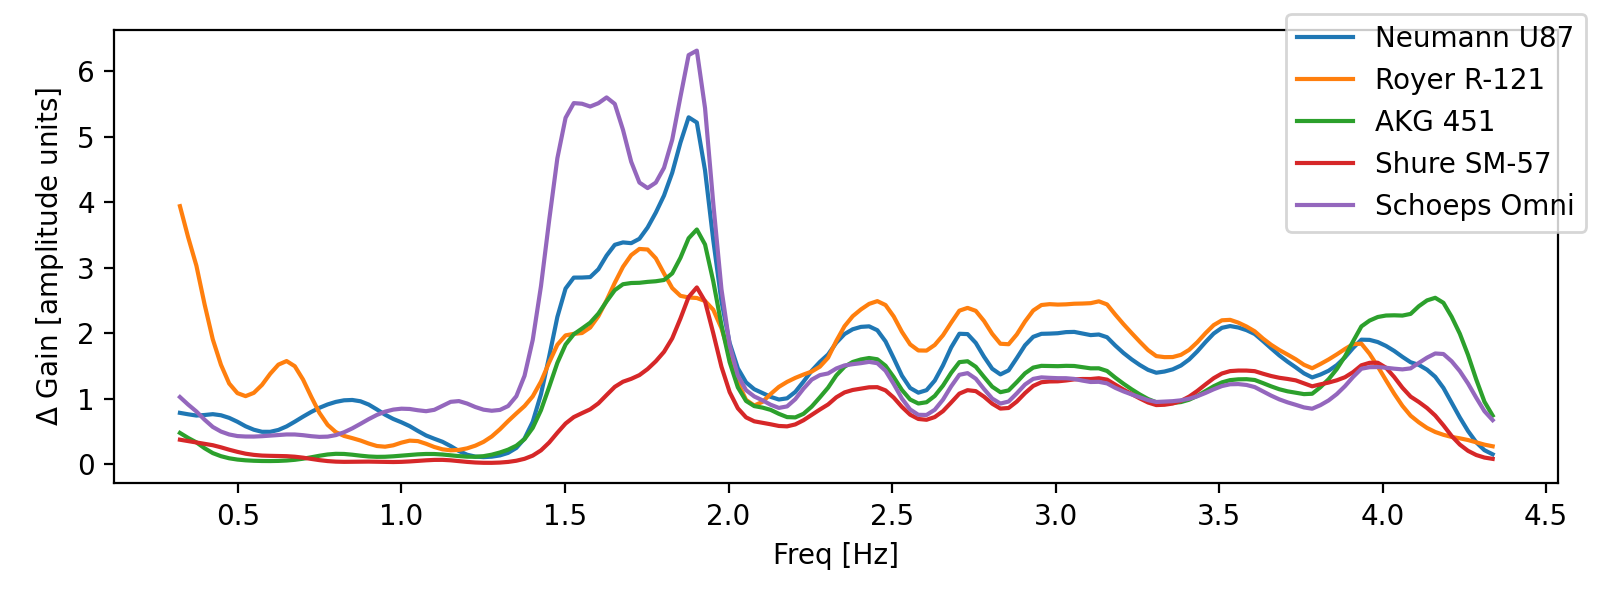

(5, 161) (161,)


In [12]:
# get microphone response functions & build relative amplitude change array (a_array)

%matplotlib notebook

# setup plot canvas
fig0 = plt.figure(figsize=(8,3))
ax0 = plt.gca()

# set path to microphone data files
path_f = path_mic + 'freqs/' # path to frequency files
path_a = path_mic + 'amps/' # path to response amplitude files

# get response filenames (for different microphones)
filelist = [x for x in os.listdir(path_f) if not x.startswith('.')]
# select a few microphones for plot
idx_list= [1,3,4,5,7] 
filelist = [filelist[idx] for idx in idx_list]

# Reference Response for Academic Dataset
f0_log = np.log10(np.array([50,200,350,500,700,1400,2000,4000,6000,8500,12000,15000,20000]))
a0 = np.array([-4,10,10,8,10,7,10,10,12,8,8,6,6])
a0_interp = interp1d(f0_log, a0,fill_value='extrapolate')
#ax0.plot(f,f0_interp(f)-10.0, label='Academic')

# Loop over chosen microphones and get differential gain over reference response
for index, file in enumerate(filelist[:]):

    core_file = file[:-6]
    
    f = np.loadtxt(path_f+core_file+'_f.txt')
    f_log = np.log10(np.loadtxt(path_f+core_file+'_f.txt'))
    
    a = np.loadtxt(path_a+core_file+'_a.txt')
    a_diff = librosa.db_to_amplitude((a-90.0)-(a0_interp(f_log)-10.0))
    
    ax0.plot(f_log,a_diff, label=core_file)
    
    if index == 0:
        a_array = a_diff
    else:
        a_array = np.vstack((a_array,a_diff))
    
ax0.set_xlabel('Freq [Hz]')
ax0.set_ylabel('$\Delta$ Gain [amplitude units]')
fig0.legend(loc=1)    

fig0.tight_layout()

print(a_array.shape,f.shape)

In [14]:
# For every microphone, interpolate, and then scale the frequencies (fft) of train_wave accordingly

%matplotlib notebook

# setup plot canvas
# fig1 = plt.figure(figsize=(8,3))
# ax1=plt.gca()

# train_wave specs
sr = 44100

# loop over training samples and filter using microphone response. 
for i,ii in enumerate(range(train_wave.shape[0])):
    
    sample = train_wave[ii,:]
    
    # use fast fourier transform to access frequency space
    sample_fourier = np.fft.rfft(sample)
    
    # get frequencies 
    freqs = np.fft.rfftfreq(n=sample.size,d=1.0/sr)
    
    # Check inverse -/
    # sample_rec = np.fft.irfft(sample_fourier)
    
    for j in range(a_array.shape[0]):
        
        a = a_array[j,:]
        inter_x = f 
        inter_y = a
        interp_a = interp1d(inter_x, inter_y, fill_value=(inter_y[0],inter_y[-1]),bounds_error=False)
        
        a_scaler = interp_a(freqs)
        
        # plot to check scaler by comparisson to previous plot 
        # should look basically the same, now the domain is finer
        # ax1.semilogx(freqs,a_scaler, label=core_file)
        
        # filter training sample wave in frequency space
        sample_fourier_scaled = np.multiply(sample_fourier,a_scaler)
        
        # convert resulting filtered wave back to real space
        sample_scaled = np.fft.irfft(sample_fourier_scaled)
        
        if (i == 0) and (j==0):
            train_wave_ext = sample_scaled
            train_labels_ext = [train_labels[ii]]
        else:
            train_wave_ext = np.vstack((train_wave_ext,sample_scaled))
            train_labels_ext.append(train_labels[ii])
            

In [34]:
# Save & Load extension of training set:

# np.savetxt(path_waves+'W_train_ext.txt',train_wave_ext)
# np.savetxt(path_labels+'y3_train_ext.txt',np.array(train_labels_ext))

train_wave_ext = np.loadtxt(path_waves+'W_train_ext.txt')
train_labels_ext = np.loadtxt(path_labels+'y3_train_ext.txt')

print(train_wave_ext.shape,train_labels_ext.shape)

(3180, 22050) (3180,)


In [37]:
# Listen to pre-augment wave example

train_idx = 19
ipd.Audio(train_wave[train_idx], rate=44100) #-/


In [40]:
# Listen to post-augment wave example

mic_idx = 1
ipd.Audio(train_wave_ext[(5)*(train_idx)+mic_idx], rate=44100) #-/


## Augmentation 2: Random Noise.

Data is augmented by adding random noise to input audio.

A difference of around 75 dB between signal and noise is considered a good. Thus we add noise such that we obtain a significant (40 dB) signal-to-noise difference. This amounts to around 1% of input amplitude and is noticeable upon listening. 

In [43]:
# Oversample adding noise to equalize classes

# 6*(173+254+209) = (1038 + 1524 +1254) = 6*636 = 3816
# We need 1524-1038 = 486 (breathy)
# We need 1524-1254 = 270 (pressed)

# librosa.db_to_amplitude(40) = 100 (signal to noise)

cb = 0# count b
cp = 0# count p
while cb < 486:
    idx = np.random.randint(636)
    #if breathy
    if int(train_labels[idx]) == 0:
        
        wave = train_wave[idx,:]
        eps = 0.01*np.max(np.abs(wave)) # 40 dB noise; 1% of amplitude
        noise = eps*np.random.normal(-1,1,22050)
        
        noisy_wave = wave + noise
        
        if (cb == 0):
            train_wave_ext_noise = noisy_wave
            train_labels_ext_noise = [train_labels[idx]]
        else:
            train_wave_ext_noise = np.vstack((train_wave_ext_noise,noisy_wave))
            train_labels_ext_noise.append(train_labels[idx])
        
        cb+=1
        
while cp < 270:  
    idx = np.random.randint(636)
    #if breathy
    if int(train_labels[idx]) == 2:
        
        wave = train_wave[idx,:]
        eps = 0.01*np.max(np.abs(wave)) # 40 dB noise; 1% of amplitude
        noise = eps*np.random.normal(-1,1,22050)
        
        noisy_wave = wave + noise
        
        train_wave_ext_noise = np.vstack((train_wave_ext_noise,noisy_wave))
        train_labels_ext_noise.append(train_labels[idx])

        cp+=1
        
print(train_wave_ext_noise.shape)
print(np.array(train_labels_ext_noise).shape)

(756, 22050)
(756,)


In [332]:
# Save/Load noise extension of training set
# np.savetxt(path_waves+'W_train_ext_noise.txt',train_wave_ext_noise)
# np.savetxt(path_labels+'y3_train_ext_noise.txt',np.array(train_labels_ext_noise))

train_wave_ext_noise= np.loadtxt(path_waves+'W_train_ext_noise.txt')
train_labels_ext_noise=np.loadtxt(path_labels+'y3_train_ext_noise.txt')


In [44]:

ipd.Audio(wave, rate=44100) #-/


In [45]:

ipd.Audio(noisy_wave, rate=44100) #-/


# Combining Datasets

Next I combine the training set with the microphone filter and noise training extensions to produce a single augmented training set.

In [3]:
# core training data
train_wave = np.loadtxt(path_waves+'W_train'+'.txt')
train_labels = np.loadtxt(path_labels+'y3_train'+'.txt')

# data extension by microphone frequency response filtering
train_wave_ext = np.loadtxt(path_waves+'W_train_ext.txt')
train_labels_ext = np.loadtxt(path_labels+'y3_train_ext.txt')

# data extension by oversampling and adding random noise
train_wave_ext_noise= np.loadtxt(path_waves+'W_train_ext_noise.txt')
train_labels_ext_noise=np.loadtxt(path_labels+'y3_train_ext_noise.txt')

# test data
test_wave = np.loadtxt(path_waves+'W_test'+'.txt')
test_labels = np.loadtxt(path_labels+'y3_test'+'.txt')

In [4]:
# Combine training datasets into an augmented training set by stacking & concatenating
train_wave_aug =np.vstack( ( train_wave , np.vstack((train_wave_ext,train_wave_ext_noise)) ) )
train_labels_aug = np.concatenate((train_labels,np.concatenate((train_labels_ext,train_labels_ext_noise)) )) 

In [5]:
# Check Balanced
occurrences0 = list(train_labels_aug).count(0)
occurrences1 = list(train_labels_aug).count(1)
occurrences2 = list(train_labels_aug).count(2)
print(occurrences0,occurrences1,occurrences2) # Balanced

1524 1524 1524


# Signal Preprocessing 
## (Get vocal cord buzz by removing all formants)

The audio we hear is the product of a source (the vocal cords) and a filter (the resonance cavities in the throat and head). The filter, by its geometric properties, amplifies certain frequencies (called formants) - this decorates/colors the sound we hear. While great for our listening pleasure, the filtered sound is too rich for a machine to learn the underlying vocal cord phonation modes. 

What we really want is the sound of the source. To this end, we implement an inverse filter to convert vocal sounds into vocal cord buzz audio. This in turn is achieved by leveraging a linear autoregressive model of the formant structure of the voice, which can be subtracted from the original signal to yield a residual wave that approximate the vocal cord buzz. 

In [30]:
def formant_signal(x,order):
    '''
    formant_signal(x,order) takes wave amplitude array (x) and returns the LPC approximation 
    (s_formant) based on a linear autoregressive model to a given specified order (order).
    
    s_formant can be understood as the (sourceless) amplitude due to the vocal formants of the signal x.
    '''
    
    a = librosa.lpc(x, order) # (x,16)
    b = np.hstack([[0], -1 * a[1:]])
    s_formant = sp.signal.lfilter(b, [1], x)
    
    return s_formant

def residual(x,order,s=None):
    '''
    residual(x,order,s) subtracts the formants from the input signal x to yield the source wave (vocal cord buzz).
    '''
    if s is None: 
        s_formant = formant_signal(x,order)
        return (x-s_formant)
    else:
        return (x-s)

def wave_to_cord(wave):
    '''
    wave_to_cord is a helper function to convert an input audio voice signal into its respective vocal cord signal.
    '''
    
    order = 16
    cord = residual(wave,order)
    
    return cord

def audio_processor(wave, sr=44100, order=16):
    '''
    Take input wave file and return image array ready for CNN.
    '''

    R_ = librosa.stft(residual(cutter(wave, sr), order), n_fft=2048) # short time fourier transform 
    Rabs_ = np.abs(R_) # absolute value of complex matrix
    RdB_ = librosa.amplitude_to_db(Rabs_, ref=np.max) # convert amplitudes to decibels
    RdB_expanded = np.expand_dims(RdB_, axis=2) # for keras
    RdB_ready = np.array([RdB_expanded, ]) # ready for keras

    return RdB_ready


In [8]:
# Pre-process training set (row by row) to obtain vocal cord buzz training set. 
train_cord = np.apply_along_axis(wave_to_cord, 1, train_wave)
train_cord_aug = np.apply_along_axis(wave_to_cord, 1, train_wave_aug)

In [9]:
# Pre-process test set (row by row) to obtain vocal cord buzz test set.
test_cord = np.apply_along_axis(wave_to_cord, 1, test_wave)

In [10]:
print(train_cord.shape,train_cord_aug.shape)

(636, 22050) (4572, 22050)


In [15]:
# Listen a couple of examples & compare: before

ipd.Audio(train_wave[242,:], rate=44100) #-/

In [16]:
# Listen a couple of examples & compare: after

ipd.Audio(train_cord[242,:], rate=44100) #-/

## EDA on audio wave amplitudes

### Histograms of processed buzz rms amplitudes

In [17]:
# get rms amplitudes
cord_amps = np.apply_along_axis(lambda row: np.sqrt(np.mean(np.abs(row)**2)), 1, train_cord)
cord_aug_amps = np.apply_along_axis(lambda row: np.sqrt(np.mean(np.abs(row)**2)), 1, train_cord_aug)
print(cord_amps.shape,cord_aug_amps.shape)

(636,) (4572,)


In [18]:
# get rough idea of scale 

print('avg rms=',(np.mean(cord_amps[train_labels==0]),np.mean(cord_amps[train_labels==1]),np.mean(cord_amps[train_labels==2])))
print('avg aug rms=',(np.mean(cord_aug_amps[train_labels_aug==0]),np.mean(cord_aug_amps[train_labels_aug==1]),np.mean(cord_aug_amps[train_labels_aug==2])))

print('avg avg rms=',np.mean(np.array([np.mean(cord_amps[train_labels==0]),np.mean(cord_amps[train_labels==1]),np.mean(cord_amps[train_labels==2])])))  
print('avg avg aug rms=',np.mean(np.array([np.mean(cord_aug_amps[train_labels_aug==0]),np.mean(cord_aug_amps[train_labels_aug==1]),np.mean(cord_aug_amps[train_labels_aug==2])])))    
      

avg rms= (0.0339413431200937, 0.023994383707010056, 0.01906976925125491)
avg aug rms= (0.03842003645356407, 0.028987424571231192, 0.02601829848236576)
avg avg rms= 0.02566849869278622
avg avg aug rms= 0.031141919835720344


<IPython.core.display.Javascript object>


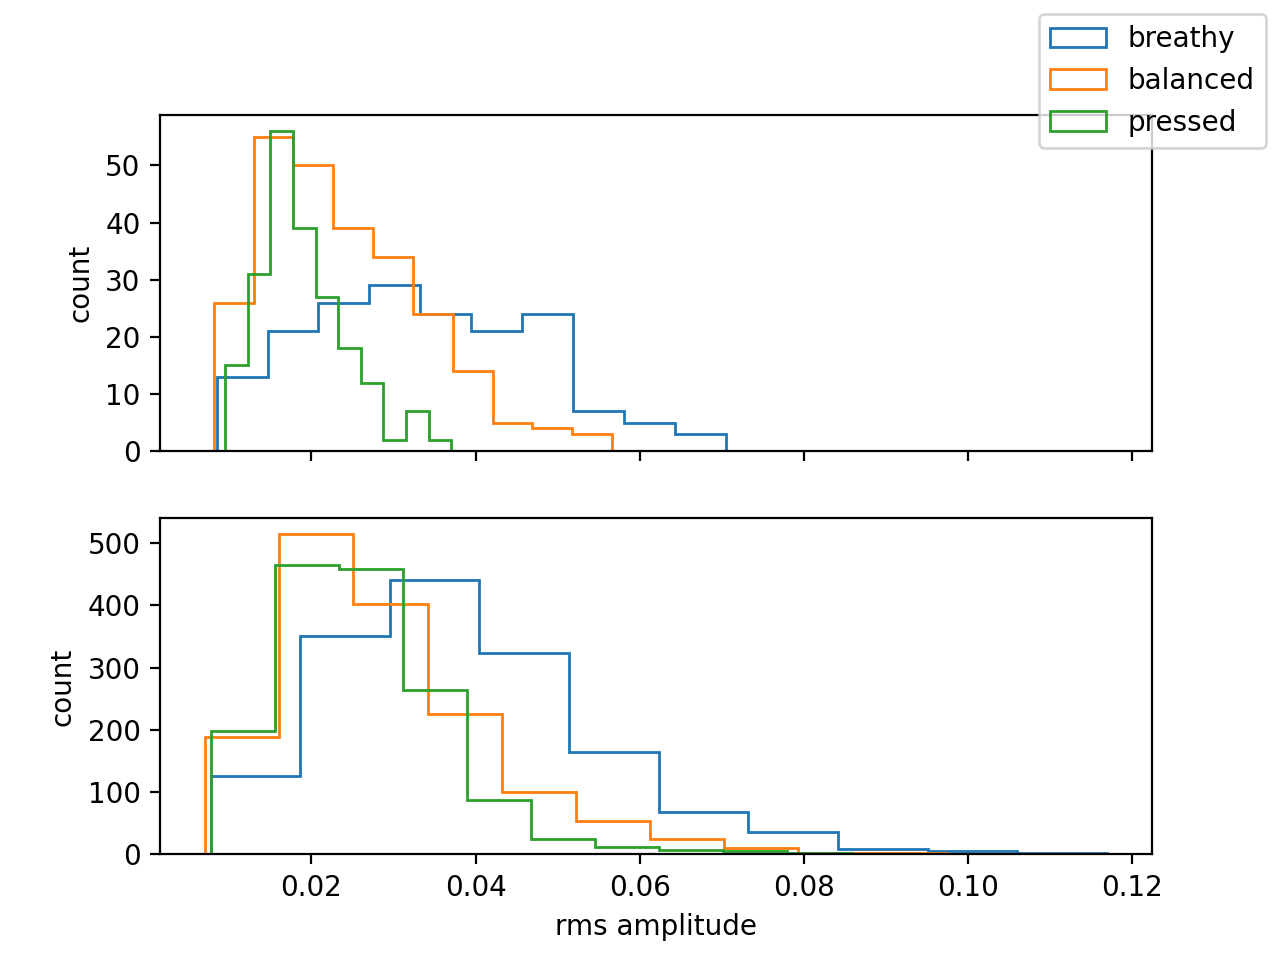

In [24]:
# Make histogram plots

%matplotlib notebook

fig2,ax2 = plt.subplots(2,1,sharex=True)

ax2[0].hist(cord_amps[train_labels==0],histtype='step',density=False,label='breathy')
ax2[0].hist(cord_amps[train_labels==1],histtype='step',density=False,label='balanced')
ax2[0].hist(cord_amps[train_labels==2],histtype='step',density=False,label='pressed')
#ax2[0].hist(cord_amps)
ax2[1].hist(cord_aug_amps[train_labels_aug==0],histtype='step',density=False,label='_nolegend_')
ax2[1].hist(cord_aug_amps[train_labels_aug==1],histtype='step',density=False,label='_nolegend_')
ax2[1].hist(cord_aug_amps[train_labels_aug==2],histtype='step',density=False,label='_nolegend_')

ax2[0].set_ylabel('count')
ax2[1].set_xlabel('rms amplitude')
ax2[1].set_ylabel('count')

fig2.legend()

## Normalization

The histograms reveal that there is some spread in rms amplitudes between the different phonation modes.
This is a consequence of variations in recording volume and pre-processing, and should have no bearing on classification - as sound volume is not a relevant feature when diagnozing phonation. Therefore we shall 
normalize the data, to level all sound volumes across all modes.


In [25]:
# Normalize training set
train_cord_norm = np.apply_along_axis(lambda row: row/np.sqrt(np.mean(np.abs(row)**2)), 1, train_cord)
train_cord_aug_norm  =np.apply_along_axis(lambda row: row/np.sqrt(np.mean(np.abs(row)**2)), 1, train_cord_aug)

In [26]:
# Normalize test set
test_cord_norm = np.apply_along_axis(lambda row: row/np.sqrt(np.mean(np.abs(row)**2)), 1, test_cord)

In [29]:
# Listen a couple of examples & compare: before

ipd.Audio(train_cord[45,:], rate=44100) #-/


In [30]:
# Listen a couple of examples & compare: after

ipd.Audio(train_cord_norm[45,:], rate=44100) #-/


In [33]:
print('before:',train_cord[16,:])

before: [ 0.27389815 -0.25491112  0.00345959 ... -0.00652368  0.01074448
  0.01653771]


In [34]:
print('after (normalized):',train_cord_norm[16,:])

after (normalized): [ 9.35459209 -8.70611753  0.11815722 ... -0.22280673  0.36696205
  0.56482126]


# Machine Learning (Convolutional Neural Network)

The core idea of our model is covert audio waves into images and then leverage the power of convolutional neural networks (CNNs) for image classification. 


The audio to image conversion is achieved by processing input audio signals into spectrograms (Frequency vs Time graphs).

In [42]:
def cord_to_image(c_wave,n_fft=2048):
    '''
    cord_to_image takes a vocal cord wave (and a fast fourier transform (FFT) window size n_fft)
    and returns a spectrogram image of the absolute fourier amplitude in decibels.
    '''
    
    R = librosa.stft(c_wave,n_fft=n_fft)
    Rabs = np.abs(R)
    RdB = librosa.amplitude_to_db(Rabs, ref=np.max)
    
    return RdB

def make_image_array(cord_array,n_fft=2048):
    '''
    make_image_array takes a 2d vocal cord array (e.g. training set) - and a FFT window size n_fft -
    and builds 3d image array, where the first dimension indexes audio files, and the 2nd and 3rd
    dimensions (frequency, time) index image pixels.
    '''
    
    c_wave_0 = cord_array[0,:]
    c_image_0 = cord_to_image(c_wave_0,n_fft)
    im_f,im_t = c_image_0.shape[0],c_image_0.shape[1]
    # print(im_f,im_t)
    
    RdB_array = np.zeros((cord_array.shape[0],im_f,im_t))
    
    for index in range(cord_array.shape[0]):
        
        c_wave = cord_array[index,:]
        c_image = cord_to_image(c_wave,n_fft)
        
        RdB_array[index,:,:] = c_image
    
    # print(RdB_array.shape)
    
    return RdB_array   

[[0.36108348 0.2931862  0.1931966  ... 0.11681895 0.03932764 0.0279549 ]
 [0.22300652 0.15983387 0.07983206 ... 0.06578445 0.06847872 0.0579765 ]
 [0.0908418  0.02897198 0.06268389 ... 0.00770415 0.02337417 0.07577303]
 ...
 [0.39476186 0.19781614 0.0012415  ... 0.00086136 0.02926729 0.06359355]
 [0.39346286 0.19611976 0.00100069 ... 0.00131003 0.02819169 0.06311223]
 [0.3930693  0.19692247 0.00050041 ... 0.00096408 0.02809815 0.06249082]]
(1025, 44)


<IPython.core.display.Javascript object>


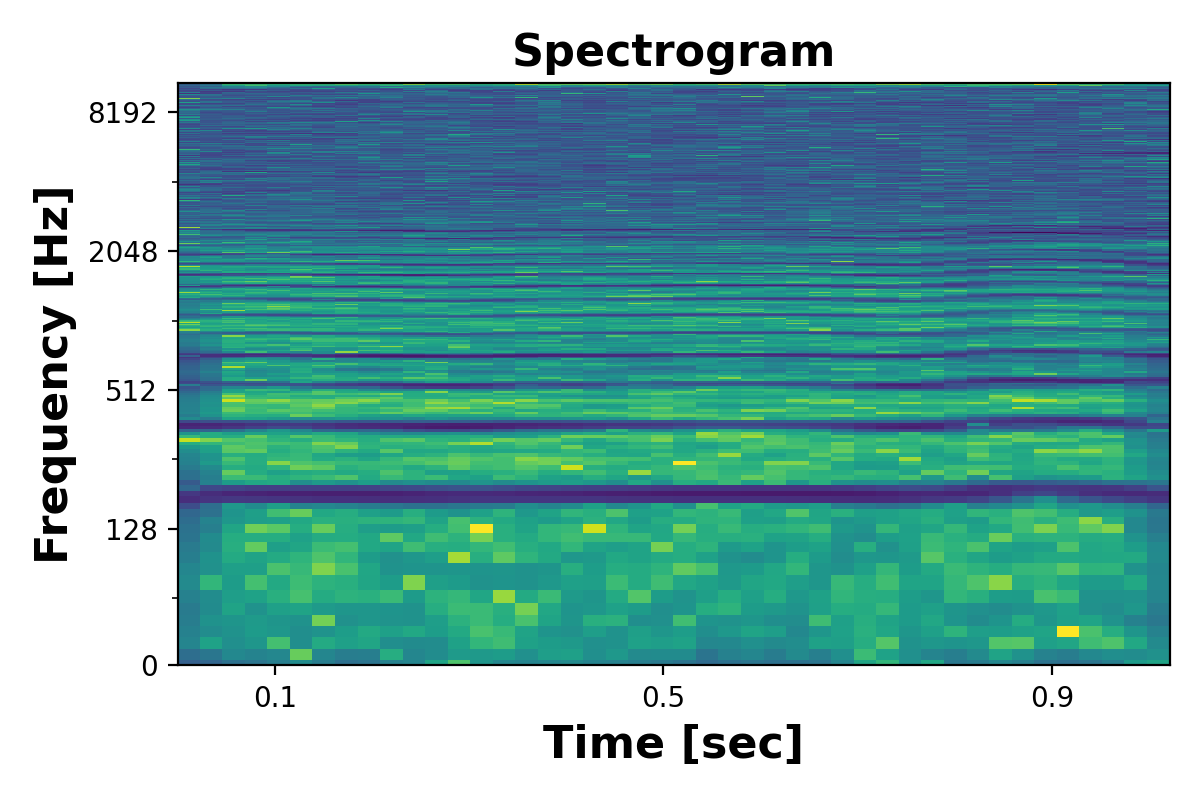

In [37]:
# Sample Spectrogram of input audio
path_mat = os.path.abspath(os.pardir+"/../Extra Data & Files/Data_extra/Data_Mat/") + "/"

plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'bold'


Rabs = np.loadtxt(path_mat+'R'+str(0)+'.txt')
print(Rabs)
print(Rabs.shape)
plt.figure(figsize=(6,4))
librosa.display.specshow(librosa.amplitude_to_db(Rabs),cmap='viridis_r', x_axis='time', y_axis='log')
plt.xticks([0.1,0.5,0.9])
plt.yticks([0,128,512,2048,8192])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Spectrogram',fontweight='bold',fontsize=16)
plt.tight_layout()

## Define network architecture

In [38]:
def build_model_arch(im_f, im_t, num_filters=8, filter_size=3, pool_size=2):
    
    # print('num_filters=',num_filters,'filter_size=',filter_size,'pool_size=',pool_size)
    # Build the model.
    model = Sequential([
      Conv2D(num_filters, filter_size, input_shape=(im_f, im_t, 1)), 
      MaxPooling2D(pool_size=pool_size),
      Flatten(),
      Dense(3, activation='softmax'),
    ])

    # Compile the model.
    model.compile(
      'adam',
      loss = 'categorical_crossentropy',
      metrics = ['accuracy'],
    )
    
    return model

def build_model(train_cord,n_fft=2048,num_filters=8,filter_size=3,pool_size=2):
    
    c_wave_0 = train_cord[0,:]
    c_image_0 = cord_to_image(c_wave_0,n_fft)
    im_f,im_t = c_image_0.shape[0],c_image_0.shape[1]
       
    model = build_model_arch(im_f, im_t, num_filters=num_filters, filter_size=filter_size, pool_size=pool_size)
    return model


## Train Model

In [39]:
def train_model(train_cord, test_cord, train_labels, test_labels,callback,n_fft=2048,epochs=16,num_filters=8,filter_size=3,pool_size=2):

    # make infrastructure
    model = build_model(train_cord,n_fft=2048,num_filters=num_filters,filter_size=filter_size,pool_size=pool_size)
    
    # pre-process the data: cord to image
    train_images = make_image_array(train_cord,n_fft)
    test_images = make_image_array(test_cord,n_fft)

    # Reshape the images.
    train_images = np.expand_dims(train_images, axis=3)
    test_images = np.expand_dims(test_images, axis=3)
    # print(train_images.shape)
    # print(test_images.shape)
    
    # Fit model
    model.fit(
      train_images,
      to_categorical(train_labels),
      epochs = epochs,
      validation_data = (test_images, to_categorical(test_labels)),
      callbacks = [callback]  
    ) 
    
    return model

### Train model with clean (non-augmented) data (to compare to prior models - from academic groups)

In [41]:
# Train clean (non-augmented) model - not normalized

callback = EarlyStopping(monitor='loss',min_delta=0.0001, patience=5)

model = train_model(train_cord, test_cord, train_labels, test_labels,callback,epochs=35)

model.save_weights('ssing_cnn_clean_v3.h5')

1025 44
(636, 1025, 44)
1025 44
(273, 1025, 44)
Epoch 1/35
20/20 [==============================] - 5s 263ms/step - loss: 365.1106 - accuracy: 0.3664 - val_loss: 86.0525 - val_accuracy: 0.4432
Epoch 2/35
20/20 [==============================] - 5s 245ms/step - loss: 58.0448 - accuracy: 0.4811 - val_loss: 20.1515 - val_accuracy: 0.5421
Epoch 3/35
20/20 [==============================] - 6s 278ms/step - loss: 9.3171 - accuracy: 0.6918 - val_loss: 6.7812 - val_accuracy: 0.6557
Epoch 4/35
20/20 [==============================] - 5s 228ms/step - loss: 1.6697 - accuracy: 0.8931 - val_loss: 5.0971 - val_accuracy: 0.6996
Epoch 5/35
20/20 [==============================] - 5s 261ms/step - loss: 0.3399 - accuracy: 0.9513 - val_loss: 4.8399 - val_accuracy: 0.6813
Epoch 6/35
20/20 [==============================] - 6s 290ms/step - loss: 0.2216 - accuracy: 0.9733 - val_loss: 5.1893 - val_accuracy: 0.6813
Epoch 7/35
20/20 [==============================] - 5s 241ms/step - loss: 0.0658 - accuracy: 0.

In [43]:
# Now lets train a model on the normalized training data (non-augmented)

callback = EarlyStopping(monitor='loss',min_delta=0.0001, patience=5)

model = train_model(train_cord_norm, test_cord_norm, train_labels, test_labels,callback,epochs=35)

model.save_weights('ssing_cnn_clean_norm_v3.h5')

Epoch 1/35
20/20 [==============================] - 4s 210ms/step - loss: 478.8354 - accuracy: 0.3522 - val_loss: 99.8961 - val_accuracy: 0.4432
Epoch 2/35
20/20 [==============================] - 4s 202ms/step - loss: 34.0285 - accuracy: 0.5613 - val_loss: 14.1454 - val_accuracy: 0.6190
Epoch 3/35
20/20 [==============================] - 4s 202ms/step - loss: 6.8783 - accuracy: 0.7610 - val_loss: 6.5586 - val_accuracy: 0.6850
Epoch 4/35
20/20 [==============================] - 4s 223ms/step - loss: 6.1247 - accuracy: 0.7689 - val_loss: 14.6287 - val_accuracy: 0.5824
Epoch 5/35
20/20 [==============================] - 4s 205ms/step - loss: 3.8239 - accuracy: 0.8333 - val_loss: 5.0159 - val_accuracy: 0.7106
Epoch 6/35
20/20 [==============================] - 5s 227ms/step - loss: 2.0080 - accuracy: 0.8947 - val_loss: 7.2556 - val_accuracy: 0.7143
Epoch 7/35
20/20 [==============================] - 5s 251ms/step - loss: 0.6442 - accuracy: 0.9387 - val_loss: 5.0849 - val_accuracy: 0.7253


Training with the non-augmented training data does not produce a significant difference between normalize and non-normalized. This suggests the machine doesn't try to learn sound volume, and is picking up on different features.

Our results on the clean training data are quite good with ~73% accuracy on the test set, where previous work by academic groups have found ~60% accuracy on a test set.

## Training model with augmented data 

What we are really interested in is a refined model which can perform well for classification in non-controlled realistic environments such as those used by singers when recording themselves at home. For this, we train our model on a training set which has been augmented to mimic different noisy environments and recording setups. 


In [44]:
# Lets train a model on the augmented training data (non-normalized)

callback = EarlyStopping(monitor='loss',min_delta=0.0001, patience=5)

model = train_model(train_cord_aug, test_cord, train_labels_aug, test_labels,callback,epochs=35)

model.save_weights('ssing_cnn_aug_v3.h5')

Epoch 1/35
143/143 [==============================] - 32s 227ms/step - loss: 60.1249 - accuracy: 0.7677 - val_loss: 8.4911 - val_accuracy: 0.7363
Epoch 2/35
143/143 [==============================] - 33s 230ms/step - loss: 0.5577 - accuracy: 0.9705 - val_loss: 5.9525 - val_accuracy: 0.7582
Epoch 3/35
143/143 [==============================] - 28s 194ms/step - loss: 0.5779 - accuracy: 0.9731 - val_loss: 12.3421 - val_accuracy: 0.6667
Epoch 4/35
143/143 [==============================] - 29s 203ms/step - loss: 1.4044 - accuracy: 0.9549 - val_loss: 9.4474 - val_accuracy: 0.7582
Epoch 5/35
143/143 [==============================] - 28s 193ms/step - loss: 5.5350e-05 - accuracy: 1.0000 - val_loss: 9.2884 - val_accuracy: 0.7692
Epoch 6/35
143/143 [==============================] - 27s 191ms/step - loss: 7.5614e-10 - accuracy: 1.0000 - val_loss: 9.2884 - val_accuracy: 0.7692
Epoch 7/35
143/143 [==============================] - 29s 204ms/step - loss: 7.5614e-10 - accuracy: 1.0000 - val_loss: 9

In [47]:
# Now lets train a model on the augmented training data (normalized)

callback = EarlyStopping(monitor='loss',min_delta=0.0001, patience=4)

model = train_model(train_cord_aug_norm, test_cord_norm, train_labels_aug, test_labels,callback,epochs=35)

model.save_weights('ssing_cnn_aug_norm_v3.h5')

Epoch 1/35
143/143 [==============================] - 31s 218ms/step - loss: 55.2179 - accuracy: 0.7244 - val_loss: 7.7097 - val_accuracy: 0.7216
Epoch 2/35
143/143 [==============================] - 29s 204ms/step - loss: 1.7810 - accuracy: 0.9488 - val_loss: 24.2808 - val_accuracy: 0.5751
Epoch 3/35
143/143 [==============================] - 31s 220ms/step - loss: 1.1658 - accuracy: 0.9606 - val_loss: 22.9797 - val_accuracy: 0.6007
Epoch 4/35
143/143 [==============================] - 34s 240ms/step - loss: 0.0297 - accuracy: 0.9980 - val_loss: 8.1929 - val_accuracy: 0.7546
Epoch 5/35
143/143 [==============================] - 38s 266ms/step - loss: 7.9018e-08 - accuracy: 1.0000 - val_loss: 8.1927 - val_accuracy: 0.7546
Epoch 6/35
143/143 [==============================] - 29s 204ms/step - loss: 7.4483e-08 - accuracy: 1.0000 - val_loss: 8.1924 - val_accuracy: 0.7546
Epoch 7/35
143/143 [==============================] - 34s 241ms/step - loss: 6.9712e-08 - accuracy: 1.0000 - val_loss: 

# Confusion Matrix

Lets visualize the results of the models.

In [48]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(4, 3))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.tight_layout()
    plt.show()

In [49]:
test_images = make_image_array(test_cord_norm,n_fft=2048)
test_images = np.expand_dims(test_images, axis=3)

predictions = model.predict(test_images[:])
cm =confusion_matrix(test_labels, np.argmax(predictions, axis=1))

<IPython.core.display.Javascript object>


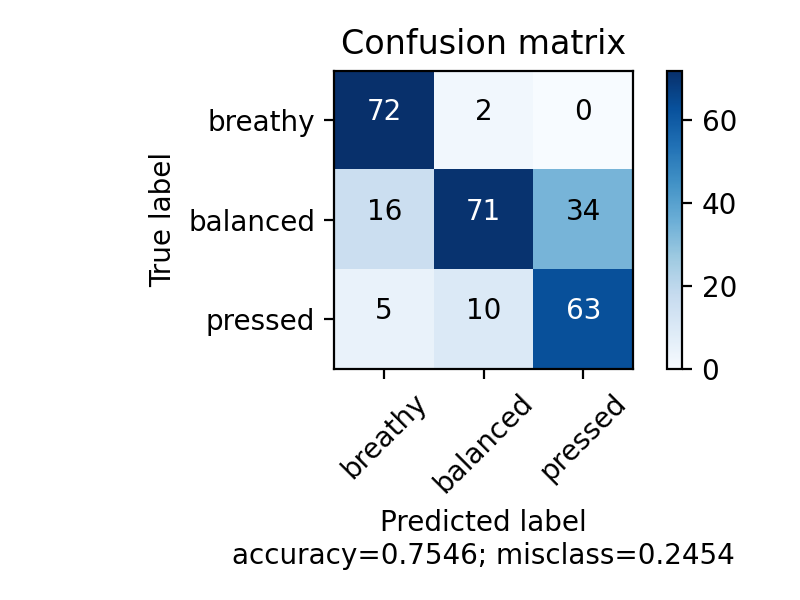

In [50]:
plot_confusion_matrix(cm,['breathy','balanced','pressed'],
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False)

# Hyperparameter Tuning
## Grid Search
Parameters: n_fft, epochs, num_filters, filter_size
* n_fft - FFT window size determines the dimensions of the spectrogram images.
* num_filters - Number of filters in convulational layer.
* filter_size - Size of convolutional layer filter.
* epochs - training epochs (use callbacks).

In [54]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV

### Adapt model builder functions for efficient grid search

In [51]:
def build_model_grid(n_fft=2048,num_filters=8,filter_size=3,pool_size=2,n_samples=22050):
    
    im_t =int(4.0*n_samples/n_fft)+1
    im_f =int(n_fft/2)+1
    
    #print(X)
    
    print('n_fft=',n_fft, 'num_filters=',num_filters,'filter_size=',filter_size,'pool_size=',pool_size)
    # Build the model.
    model = Sequential([
      Conv2D(num_filters, filter_size, input_shape=(im_f, im_t, 1)), #Dense(num_filters, activation='relu')
      MaxPooling2D(pool_size=pool_size),
      Flatten(),
      Dense(3, activation='softmax'),
    ])

    # Compile the model.
    model.compile(
      'adam',
      loss='categorical_crossentropy',
      metrics=['accuracy'],
    )
    
    return model


In [52]:
def time_bins(n_samples,n_fft):
    return int(4.0*n_samples/n_fft)+1

def freq_bins(n_fft):
    return int(n_fft/2)+1

In [53]:
nfft_list = [128,256,512,1024,2048,4096,8192]
for n_fft in nfft_list:
    print('image dimensions:',freq_bins(n_fft),time_bins(22050, n_fft))

image dimensions: 65 690
image dimensions: 129 345
image dimensions: 257 173
image dimensions: 513 87
image dimensions: 1025 44
image dimensions: 2049 22
image dimensions: 4097 11


In [129]:
# Re-split for grid-search
# Split Training Data into new training and validation sets
idx_cut = 454 # roughly 70 percent of 636

X , y = train_cord_norm, train_labels
X_train, X_val, y_train, y_val = X[:idx_cut], X[idx_cut:], y[:idx_cut], y[idx_cut:]

X_aug , y_aug = train_cord_aug_norm, train_labels_aug
X_train_aug, y_train_aug = X_aug[:int(5*idx_cut)], y_aug[:int(5*idx_cut)]

split_index = [-1 if x < idx_cut else 0 for x in range(X.shape[0])]

# Use the list to create PredefinedSplit
pds = PredefinedSplit(test_fold = split_index)

In [55]:
# make gridsearch model

callback = EarlyStopping(monitor='loss',min_delta=0.0001, patience=5)
model = KerasClassifier(build_fn=build_model_grid, epochs=30, verbose=1)


In [131]:
# Perform GridSearch

n_fft_list = [128,256,512,1024,2048,4096,8192]

num_filters_list = [4,8,12]
filter_size_list = [2,3,6]

for n_fft in n_fft_list:
    
    param_grid = dict(
                        n_fft=[n_fft] , num_filters=num_filters_list, filter_size=filter_size_list
                     )
    
    grid = GridSearchCV(estimator=model, cv=pds, param_grid=param_grid) #verbose=20
    
    train_images = make_image_array(X,n_fft)
    print(train_images.shape)
    train_images = np.expand_dims(train_images, axis=3)
    
    grid_result = grid.fit(train_images, y, callbacks=[callback])
    
    cv_results_df = pd.DataFrame(grid_result.cv_results_)
    cv_results_df.to_csv('gridsearch_'+str(n_fft)+'.csv')

65 690
(636, 65, 690)
(636, 65, 690)
n_fft= 128 num_filters= 4 filter_size= 2 pool_size= 2
Epoch 1/30
15/15 [==============================] - 2s 135ms/step - loss: 361.7470 - accuracy: 0.3634
Epoch 2/30
15/15 [==============================] - 2s 161ms/step - loss: 230.4049 - accuracy: 0.3921
Epoch 3/30
15/15 [==============================] - 2s 161ms/step - loss: 79.7205 - accuracy: 0.3899
Epoch 4/30
15/15 [==============================] - 2s 130ms/step - loss: 69.4340 - accuracy: 0.3744
Epoch 5/30
15/15 [==============================] - 2s 128ms/step - loss: 44.4264 - accuracy: 0.4383
Epoch 6/30
15/15 [==============================] - 2s 151ms/step - loss: 14.3407 - accuracy: 0.5374
Epoch 7/30
15/15 [==============================] - 2s 141ms/step - loss: 5.9352 - accuracy: 0.6806
Epoch 8/30
15/15 [==============================] - 2s 124ms/step - loss: 4.6335 - accuracy: 0.6740
Epoch 9/30
15/15 [==============================] - 2s 162ms/step - loss: 6.7308 - accuracy: 0.6123
E

15/15 [==============================] - 5s 352ms/step - loss: 1.0933 - accuracy: 0.9251
Epoch 6/30
15/15 [==============================] - 5s 347ms/step - loss: 0.3316 - accuracy: 0.9626
Epoch 7/30
15/15 [==============================] - 5s 342ms/step - loss: 0.1674 - accuracy: 0.9846
Epoch 8/30
15/15 [==============================] - 5s 354ms/step - loss: 0.0267 - accuracy: 0.9956
Epoch 9/30
15/15 [==============================] - 5s 343ms/step - loss: 0.0133 - accuracy: 0.9956
Epoch 10/30
15/15 [==============================] - 5s 346ms/step - loss: 7.9700e-05 - accuracy: 1.0000
Epoch 11/30
15/15 [==============================] - 5s 345ms/step - loss: 1.0640e-04 - accuracy: 1.0000
Epoch 12/30
15/15 [==============================] - 5s 342ms/step - loss: 3.5820e-05 - accuracy: 1.0000
Epoch 13/30
15/15 [==============================] - 5s 344ms/step - loss: 2.3242e-05 - accuracy: 1.0000
Epoch 14/30
15/15 [==============================] - 5s 357ms/step - loss: 1.5709e-05 - acc

15/15 [==============================] - 6s 388ms/step - loss: 3.6678e-04 - accuracy: 1.0000
Epoch 17/30
15/15 [==============================] - 7s 467ms/step - loss: 3.4024e-04 - accuracy: 1.0000
Epoch 18/30
15/15 [==============================] - 6s 389ms/step - loss: 3.2084e-04 - accuracy: 1.0000
Epoch 19/30
15/15 [==============================] - 6s 412ms/step - loss: 3.0527e-04 - accuracy: 1.0000
Epoch 20/30
15/15 [==============================] - 6s 432ms/step - loss: 2.8631e-04 - accuracy: 1.0000
Epoch 21/30
6/6 [==============================] - 1s 161ms/step - loss: 2.0506 - accuracy: 0.5824
n_fft= 256 num_filters= 8 filter_size= 6 pool_size= 2
Epoch 1/30
15/15 [==============================] - 6s 370ms/step - loss: 520.8056 - accuracy: 0.3877
Epoch 2/30
15/15 [==============================] - 8s 520ms/step - loss: 81.7255 - accuracy: 0.4009
Epoch 3/30
15/15 [==============================] - 7s 479ms/step - loss: 14.2182 - accuracy: 0.5881
Epoch 4/30
15/15 [============

15/15 [==============================] - 3s 179ms/step - loss: 0.0203 - accuracy: 0.9978
Epoch 16/30
15/15 [==============================] - 3s 175ms/step - loss: 8.8715e-07 - accuracy: 1.0000
Epoch 17/30
15/15 [==============================] - 2s 165ms/step - loss: 2.7372e-04 - accuracy: 1.0000
Epoch 18/30
15/15 [==============================] - 3s 178ms/step - loss: 6.9577e-05 - accuracy: 1.0000
Epoch 19/30
15/15 [==============================] - 3s 170ms/step - loss: 3.8135e-06 - accuracy: 1.0000
Epoch 20/30
15/15 [==============================] - 2s 160ms/step - loss: 3.0492e-06 - accuracy: 1.0000
Epoch 21/30
6/6 [==============================] - 0s 56ms/step - loss: 4.7358 - accuracy: 0.6978
n_fft= 512 num_filters= 12 filter_size= 3 pool_size= 2
Epoch 1/30
15/15 [==============================] - 3s 219ms/step - loss: 474.5516 - accuracy: 0.3656
Epoch 2/30
15/15 [==============================] - 3s 209ms/step - loss: 136.4836 - accuracy: 0.4075
Epoch 3/30
15/15 [===========

15/15 [==============================] - 3s 216ms/step - loss: 2.1289 - accuracy: 0.9163
Epoch 13/30
15/15 [==============================] - 3s 192ms/step - loss: 6.5277 - accuracy: 0.8326
Epoch 14/30
15/15 [==============================] - 3s 226ms/step - loss: 25.4421 - accuracy: 0.7070
Epoch 15/30
15/15 [==============================] - 3s 219ms/step - loss: 22.5251 - accuracy: 0.7225
Epoch 16/30
15/15 [==============================] - 3s 193ms/step - loss: 10.3478 - accuracy: 0.7863
Epoch 17/30
15/15 [==============================] - 3s 187ms/step - loss: 1.4441 - accuracy: 0.9471
Epoch 18/30
15/15 [==============================] - 4s 237ms/step - loss: 0.6947 - accuracy: 0.9626
Epoch 19/30
15/15 [==============================] - 3s 182ms/step - loss: 0.9384 - accuracy: 0.9670
Epoch 20/30
15/15 [==============================] - 3s 194ms/step - loss: 0.6040 - accuracy: 0.9604
Epoch 21/30
15/15 [==============================] - 3s 202ms/step - loss: 0.9528 - accuracy: 0.9537

15/15 [==============================] - 5s 366ms/step - loss: 1.6259 - accuracy: 0.9207
Epoch 8/30
15/15 [==============================] - 5s 321ms/step - loss: 0.3950 - accuracy: 0.9714
Epoch 9/30
15/15 [==============================] - 5s 330ms/step - loss: 0.0127 - accuracy: 0.9934
Epoch 10/30
15/15 [==============================] - 5s 334ms/step - loss: 0.0395 - accuracy: 0.9956
Epoch 11/30
15/15 [==============================] - 5s 330ms/step - loss: 0.0459 - accuracy: 0.9934
Epoch 12/30
15/15 [==============================] - 5s 334ms/step - loss: 0.2463 - accuracy: 0.9780
Epoch 13/30
15/15 [==============================] - 5s 323ms/step - loss: 0.0347 - accuracy: 0.9956
Epoch 14/30
15/15 [==============================] - 6s 368ms/step - loss: 0.0113 - accuracy: 0.9978
Epoch 15/30
15/15 [==============================] - 5s 328ms/step - loss: 0.0070 - accuracy: 0.9978
Epoch 16/30
15/15 [==============================] - 5s 327ms/step - loss: 6.3454e-05 - accuracy: 1.0000


15/15 [==============================] - 3s 221ms/step - loss: 51.8195 - accuracy: 0.5352
Epoch 4/30
15/15 [==============================] - 3s 206ms/step - loss: 7.7892 - accuracy: 0.8018
Epoch 5/30
15/15 [==============================] - 3s 215ms/step - loss: 1.3749 - accuracy: 0.9383
Epoch 6/30
15/15 [==============================] - 3s 219ms/step - loss: 0.2746 - accuracy: 0.9692
Epoch 7/30
15/15 [==============================] - 3s 212ms/step - loss: 0.1184 - accuracy: 0.9890
Epoch 8/30
15/15 [==============================] - 3s 209ms/step - loss: 0.0072 - accuracy: 0.9978
Epoch 9/30
15/15 [==============================] - 3s 225ms/step - loss: 1.7047e-04 - accuracy: 1.0000
Epoch 10/30
15/15 [==============================] - 3s 208ms/step - loss: 4.9024e-05 - accuracy: 1.0000
Epoch 11/30
15/15 [==============================] - 3s 207ms/step - loss: 8.8100e-06 - accuracy: 1.0000
Epoch 12/30
15/15 [==============================] - 3s 200ms/step - loss: 5.7952e-06 - accuracy

15/15 [==============================] - 2s 147ms/step - loss: 0.1124 - accuracy: 0.9846
Epoch 21/30
15/15 [==============================] - 2s 140ms/step - loss: 0.0389 - accuracy: 0.9934
Epoch 22/30
15/15 [==============================] - 2s 142ms/step - loss: 0.4896 - accuracy: 0.9493
Epoch 23/30
15/15 [==============================] - 2s 157ms/step - loss: 0.0493 - accuracy: 0.9912
Epoch 24/30
15/15 [==============================] - 2s 144ms/step - loss: 5.7504e-08 - accuracy: 1.0000
Epoch 25/30
15/15 [==============================] - 2s 141ms/step - loss: 2.3632e-08 - accuracy: 1.0000
Epoch 26/30
15/15 [==============================] - 2s 159ms/step - loss: 3.2297e-08 - accuracy: 1.0000
Epoch 27/30
15/15 [==============================] - 2s 151ms/step - loss: 3.4922e-08 - accuracy: 1.0000
Epoch 28/30
15/15 [==============================] - 2s 159ms/step - loss: 3.5185e-08 - accuracy: 1.0000
Epoch 29/30
6/6 [==============================] - 0s 64ms/step - loss: 4.1851 - ac

Epoch 13/30
15/15 [==============================] - 4s 268ms/step - loss: 4.3884e-05 - accuracy: 1.0000
Epoch 14/30
15/15 [==============================] - 4s 267ms/step - loss: 4.1521e-05 - accuracy: 1.0000
Epoch 15/30
15/15 [==============================] - 4s 268ms/step - loss: 4.0131e-05 - accuracy: 1.0000
Epoch 16/30
6/6 [==============================] - 0s 65ms/step - loss: 2.2228 - accuracy: 0.6923
n_fft= 4096 num_filters= 12 filter_size= 6 pool_size= 2
Epoch 1/30
15/15 [==============================] - 5s 305ms/step - loss: 629.0314 - accuracy: 0.3700
Epoch 2/30
15/15 [==============================] - 5s 325ms/step - loss: 182.9231 - accuracy: 0.3568
Epoch 3/30
15/15 [==============================] - 5s 322ms/step - loss: 29.1032 - accuracy: 0.5771
Epoch 4/30
15/15 [==============================] - 5s 303ms/step - loss: 4.8417 - accuracy: 0.7863
Epoch 5/30
15/15 [==============================] - 5s 308ms/step - loss: 0.8713 - accuracy: 0.9273
Epoch 6/30
15/15 [========

15/15 [==============================] - 2s 159ms/step - loss: 2.0282e-05 - accuracy: 1.0000
Epoch 13/30
15/15 [==============================] - 3s 169ms/step - loss: 1.7590e-05 - accuracy: 1.0000
Epoch 14/30
15/15 [==============================] - 3s 173ms/step - loss: 1.6227e-05 - accuracy: 1.0000
Epoch 15/30
15/15 [==============================] - 3s 176ms/step - loss: 1.5042e-05 - accuracy: 1.0000
Epoch 16/30
6/6 [==============================] - 0s 56ms/step - loss: 2.2017 - accuracy: 0.6648
n_fft= 8192 num_filters= 4 filter_size= 6 pool_size= 2
Epoch 1/30
15/15 [==============================] - 3s 188ms/step - loss: 109.6864 - accuracy: 0.3855
Epoch 2/30
15/15 [==============================] - 3s 188ms/step - loss: 10.8175 - accuracy: 0.5969
Epoch 3/30
15/15 [==============================] - 3s 192ms/step - loss: 4.6341 - accuracy: 0.7048
Epoch 4/30
15/15 [==============================] - 3s 186ms/step - loss: 2.9958 - accuracy: 0.8040
Epoch 5/30
15/15 [==================

### GridSearch found optimal the hyperparameters (among those varied in search) 

Optimized Params = (n_fft= 1024 num_filters= 12 filter_size= 3 pool_size= 2)

Our prior architecture and image dimensions (n_fft= 1024 num_filters= 8 filter_size= 3 pool_size= 2) are already near optimal and thus the model likely will further improve by tweaking this hyperparameter set.

# Extending analyses to sung phrases (for web app)

The strategy to analyze longer recordings is as follows:

* Chop the audio into half second bins.
* Detect voiced (sung) bins.
* Assess whether sung pitch is stable within voice bins.
* For every voiced and pitch-stable bin, classify by phonation mode using the CNN model.

In [29]:
def load_model():
    '''
    Helper function to load model
    '''
    
    im_f= 1025
    im_t= 44

    num_filters = 8
    filter_size = 3
    pool_size = 2

    # Build the model.
    model = Sequential([
      Conv2D(num_filters, filter_size, input_shape=(im_f, im_t, 1)),
      MaxPooling2D(pool_size=pool_size),
      Flatten(),
      Dense(3, activation='softmax'),
    ])

    # Compile the model.
    model.compile(
      'adam',
      loss='categorical_crossentropy',
      metrics=['accuracy'],
    )

    # Load pre-trained weights

    model.load_weights(os.getcwd()+'/ssing_cnn_v1.h5') # example model

    return model

def model_prediction(model,wave):
    '''
    Output model prediction given model and unprocessed audio wave input.
    '''
    #model = load_model()

    RdB_ready = audio_processor(wave, sr=44100, order=16)
    predict = model.predict(RdB_ready)
    prediction = np.argmax(predict, axis=1)[0]
    return prediction

In [32]:
def make_plot_pitches(wave,chunk_labels,chunk_size,class_array,sr=44100):
    '''
    Function to produce classification figure.
    '''
    
    plt.clf()

    # Determine pitch and times of sung pitches
    f0, voiced_flag, voiced_probs = librosa.pyin(y=wave, sr=sr, fmin=librosa.note_to_hz('C3'), fmax=librosa.note_to_hz('C5'))
    times = librosa.times_like(f0, sr=44100)

    # range of pitches
    max_f = np.nanmax(f0)
    min_f = np.nanmin(f0)

    # convert reference pitch frequencies to notes for plotting
    ref_values = 261.3 * (2.0 ** np.linspace(-2.0, 2.0, 2 * 24))
    ref_ticks = librosa.hz_to_note(261.3 * (2.0 ** np.linspace(-2.0, 2.0, 2 * 24)))
    
    # plot pitches over phrase time
    plt.plot(times, f0, color='k')
    plt.fill_between(times, 35 / 36 * f0, 36 / 35 * f0, color='lightgrey')

    # chop audio into half second chunks
    for chunk in range(len(chunk_labels)):
        
        alpha = 1.0
        if chunk_labels[chunk] == 0: # unvoiced
            col = 'w'
        if chunk_labels[chunk] == 1: # unstable pitch
            col = 'w'  # 'r'
        if chunk_labels[chunk] == 2: # voiced and stable
            
            if class_array[chunk] == 0: # breathy
                col = 'gold'

            if class_array[chunk] == 1: # balanced
                col = 'lightblue'

            if class_array[chunk] == 2: # pressed
                col = 'red'
                alpha = 0.85

        plt.axvspan(chunk * chunk_size / sr, (chunk + 1) * chunk_size / sr, facecolor=col, alpha=alpha, zorder=-1)

        for value in ref_values[np.logical_and((ref_values < (18 / 17) * max_f), (ref_values > min_f * (17 / 18)))]:
            plt.axhline(value, color='k', linestyle=':', linewidth=0.5)

        plt.semilogy()
        ax = plt.gca()
        ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
        plt.yticks(ref_values, ref_ticks)

        ax.set_xlim(left=-0.01)
        ax.set_ylim(top=(18 / 17) * max_f, bottom=min_f * (17 / 18))
        ax.set_xlabel('time [s]', weight='bold')
        ax.set_xticks(range(0, int(np.ceil(times[-1]) + 1)))

    figc = plt.gcf()
    figc.patch.set_facecolor('gainsboro')  #whitesmoke
    figc.patch.set_alpha(0.20)
    figc.tight_layout()
    figc.subplots_adjust(bottom=0.15)
    
    plt.show()
    
    return 1



<IPython.core.display.Javascript object>


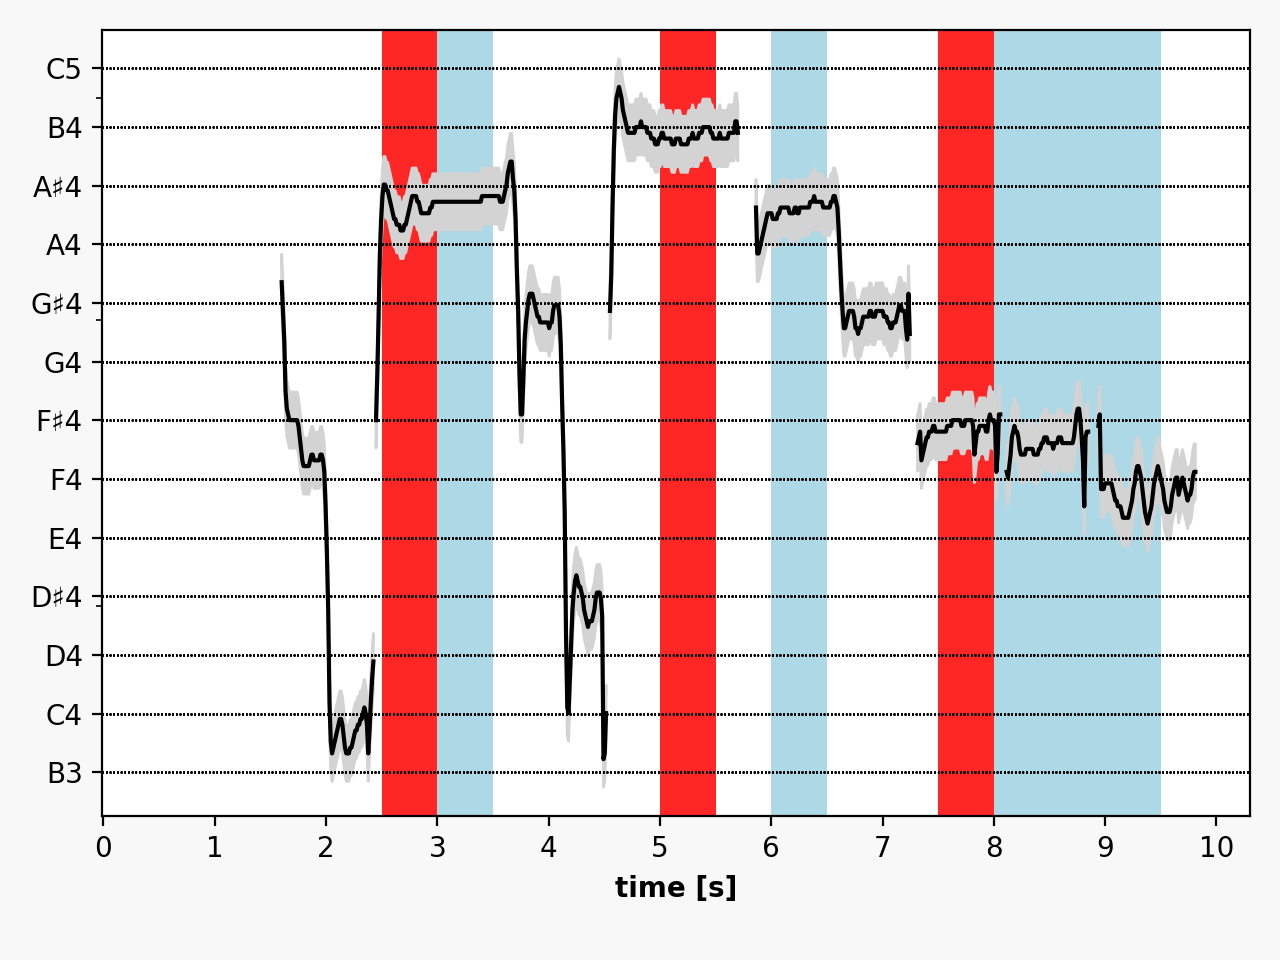

In [35]:
%matplotlib notebook

wave, sr = librosa.load(os.path.abspath(os.pardir+"/Flask_App/static/uploads/example_long.wav"),sr=44100)
                
# Load Model
model = load_model()

chunk_size = 22050
class_array = np.zeros(int(np.ceil(len(wave) // chunk_size)), dtype=int)
chunk_lab = np.zeros(int(np.ceil(len(wave) // chunk_size)), dtype=int)

# chop audio into half second chunks
for chunk in range(len(chunk_lab)):
    # within this chunk, compare the average pitch to the start and end pitches
    # if the standard deviation is within a quarter tone of the mean, chunk is pitch-stable

    wavelet = wave[chunk * chunk_size:(chunk + 1) * chunk_size]

    f0_chunk, voiced_flag, voiced_probs = librosa.pyin(y=wavelet, sr=44100, fmin=librosa.note_to_hz('C3'),fmax=librosa.note_to_hz('C5'))
    avg = np.nanmean(f0_chunk)
    std = np.nanstd(f0_chunk)

    if np.count_nonzero(voiced_flag == False) > 8:
        chunk_lab[chunk] = 0 # not voiced
    else:
        if (avg * (35 / 36) < avg - std) and (avg * (36 / 35) > avg + std):  # within a semitone
            # classify this piece
            chunk_lab[chunk] = 2 # voiced and stable pitch
            class_array[chunk] = model_prediction(model, wavelet)

        else: # unstable pitch
            # don't classify 
            chunk_lab[chunk] = 1 # voiced and pitch change

success = make_plot_pitches(wave, chunk_lab, chunk_size, class_array)
